In [3]:
import nltk
import json
import os.path
import collections
import itertools
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Streams a json input file for a specific number of lines
# and returns the number of lines as json documents
def readDocs(fileName, limit = -1):
    docs = []
    with open(fileName, 'r') as f:
        for i, line in enumerate(f):
            if limit != -1 and i > limit:
                break
            docs.append(json.loads(line))
    return docs

# Reads and tokenizes a certain about of documents
def readAndTokenize(fileName, limit):
    # Steam the docs until we reach our limit
    docs = readDocs(fileName, limit)

    # Tokenize each document and store on a new key the tokenized version
    # of that document
    for doc in docs:
        doc["tokens"] = nltk.word_tokenize(doc["text"])

    return docs

# Sorts the summarized documents
def sortSummarized(summary):
    return collections.OrderedDict(sorted(summary.items(), key=lambda t: t[1], reverse = True))

# Writes json documents into a file
def writeJSONTOFile(fileName, docs):
    with open(fileName, 'w', buffering=20*(1024**2)) as f:
        for doc in docs:
            f.write(json.dumps(doc) + '\n')

# Creates a new summary file in html
def writeSummaryLimitedToHTML(fileName, summary):
    with open(fileName, 'w', buffering=20*(1024**2)) as f:
        # move the the start of the file
        f.seek(0)
        f.write("<table>\n")
        f.write("  <thead>\n")
        f.write("   <tr>\n")
        f.write("     <th>Token</td>\n")
        f.write("     <th>Count</td>\n")
        f.write("   </tr>\n")
        f.write("  </thead>\n")
        f.write("  <tbody>\n")
        for key, value in summary:
            f.write("   <tr>\n")
            f.write("     <td>" + str(key) + "</td>\n")
            f.write("     <td>" + str(value) + "</td>\n")
            f.write("   </tr>\n")
        f.write("  </tbody>\n")
        f.write("</table>\n")
        # remove any extra lines incase there was already a file
        f.truncate()

# Summarizes a list of documents and their tokens into a count
# based on the number of times a token is used
def summarizeTokenUsage(docs):
    tokens = {}
    # itterate over each document
    for doc in docs:
        # grab the tokens
        for token in doc["tokens"]:
            t = token.lower()
            # if the token exists already we will increment it by one
            if t in tokens:
                tokens[t] = tokens[t] + 1
            # else we will create it in our token dict and set it to 1
            else:
                tokens[t] = 1

    return sortSummarized(tokens)

# Returns if the rating is good or bad
def goodOrBad(rating):
    return 0 if rating < 3 else 1

# Adds tokenMapping to the documents
def mapTokensInReview(tokenMap, docs, tokenLimit):
    # get the keys of the tokens this will be a list of words
    keys = list(tokenMap.keys())[:tokenLimit]
    mappedTokens = []
    ratings = []
    # itterate over each document
    for doc in docs:
        # create a new list on the
        doc["tokenMapping"] = []
        # create a new set of uniq tokens
        uniq = set(doc["tokens"])
        
        for token in keys:
            doc["tokenMapping"].append(1 if token in uniq else 0)
        
        mappedTokens.append(doc["tokenMapping"])
        ratings.append(doc["stars"])
        
    return mappedTokens, ratings

In [4]:


#         # for each uniq token
#         for token in uniq:
#             try:
#                 # get the tokens index
#                 index = keys.index(token)
#                 mapped = [index, goodOrBad(doc["stars"]), doc["stars"], doc["tokens"].count(token)]
#                 # append to the mapping of the tokens the scores and information
#                 # about each token that was used in the review
#                 doc["tokenMapping"].append(mapped)
#                 # also append the mapped tokens to a universal list from all docs
#                 mappedTokens.append(mapped)
#             except ValueError:
#                 # move on the token isn't in the list
#                 continue

INDEX = 0
GOOD_BAD = 1
STARS = 2
COUNT = 3

nltk.download('punkt')
sourceFile = '/yelp-data/yelp-reviews.json'
tokenizedFile = '/yelp-data/yelp-reviews-tokenized.json'
tokenSummaryFile = '/yelp-data/yelp-reviews-token-summary.json'
tokenMapped = '/yelp-data/yelp-reviews-token-mapped.json'
limitedSummaryFile = '/yelp-data/results.html'
summaryExist = os.path.exists(tokenSummaryFile)
tokenizedExists = os.path.exists(tokenizedFile)
tokenizedMappedExists = os.path.exists(tokenMapped)

documentLimit = 50000

docs = []
summary = collections.OrderedDict()
mappedTokens = []

if tokenizedMappedExists:
    mappedTokens = readDocs(tokenMapped)
    summary = sortSummarized(readDocs(tokenSummaryFile, 1)[0])
    docs = readDocs(tokenizedFile, documentLimit)
else:
    # check if we have previously summarized our records
    if summaryExist:
        print("Reading Summarized Tokenized File")
        summary = sortSummarized(readDocs(tokenSummaryFile, 1)[0])
        docs = readDocs(tokenizedFile, documentLimit)
    else:
        # check if we should read the raw data source
        if tokenizedExists == False:
            print("Reading Raw Data File")
            docs = readAndTokenize(sourceFile, documentLimit)
        # if not we should read from the already tokenized source file
        else:
            print("Reading Existing Tokenized File")
            docs = readDocs(tokenizedFile, documentLimit)
            print("Finished Reading Tokenized File")

    # create a new summary of our tokens
    summary = summarizeTokenUsage(docs)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Reading Existing Tokenized File
Finished Reading Tokenized File


In [5]:
tokensMatrix, ratings = mapTokensInReview(summary, docs, 2500)
x, x1, y, y1 = train_test_split(tokensMatrix, ratings, test_size=10000, random_state=42)
print('X Size: %d' % len(x))
print('Y Size: %d' % len(y))
print('X1 Size: %d' % len(x1))
print('Y1 Size: %d' % len(y1))

X Size: 40001
Y Size: 40001
X1 Size: 10000
Y1 Size: 10000


In [6]:
# Create linear regression object
regr = sklearn.linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x, y)

 # The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % np.mean((regr.predict(x1) - y1) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x1, y1))

('Coefficients: \n', array([-0.14630846, -0.10119522,  0.01410366, ...,  0.02680318,
       -0.01673418, -0.16783905]))
Mean squared error: 1.03
Variance score: 0.50


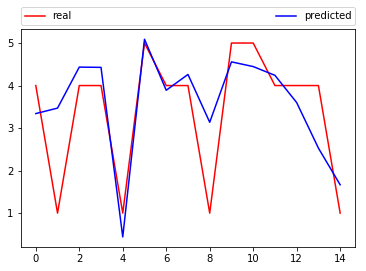

In [7]:
# Plot outputs
count = 15
plt.plot(y1[:count], color='red', label="real")
plt.plot( regr.predict(x1[:count]), color='blue', label="predicted")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)


In [ ]:
print("Writing Results:")
#     print("- Writing Limited Summarized To HTML:")
#     writeSummaryLimitedToHTML(limitedSummaryFile, limitedSummary)

if tokenizedMappedExists == False:
    print("- Writing Mapped Tokens:")
    writeJSONTOFile(tokenMapped, mappedTokens)
if tokenizedExists == False:
    print("- Writing Tokenized Documents:")
    writeJSONTOFile(tokenizedFile, docs)
if summaryExist == False:
    print("- Writing Summarized:")
    writeJSONTOFile(tokenSummaryFile, [summary])